<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-fundamentals/unit06-deep-learning-tips-and-tricks/02_lightning_learning_rate_schedulers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Rate Schedulers

**Reference**

[Learning Rates and Learning Rate Schedulers](https://lightning.ai/pages/courses/deep-learning-fundamentals/unit-6-overview-essential-deep-learning-tips-tricks/unit-6.2-learning-rates-and-learning-rate-schedulers/)

## 1) Setup

In [ ]:
!pip install torch torchvision torchaudio
!pip install lightning
!pip install torchmetrics
!pip install mlxtend==0.21.0

In [2]:
!lightning --version

lightning, version 2.0.2


In [ ]:
!wget https://github.com/Lightning-AI/dl-fundamentals/raw/main/unit06-dl-tips/6.2-learning-rates/shared_utilities.py

In [8]:
import torch
import torchvision
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import torchmetrics as tm

from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler

from shared_utilities import CustomDataModule, LightningModel, PyTorchMLP

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## 2) Learning Rate Finder

In [6]:
torch.manual_seed(123)

dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

In [7]:
!mkdir -p my_logs

In [ ]:
torch.manual_seed(123)

print("Torch CUDA available?", torch.cuda.is_available())

trainer = L.Trainer(
  max_epochs=100,
  accelerator="auto", # set to "auto" or "gpu" to use GPUs if available
  devices="auto",      # Uses all available GPUs if applicable
  deterministic=True,
  logger=CSVLogger(save_dir="my_logs", name="my-model")
)

# Create a Tuner
tuner = Tuner(trainer)

# finds learning rate automatically 
# sets hparams.lr or hparams.learning_rate to that learning rate
lr_finder = tuner.lr_find(
  model=lightning_model,
  datamodule=dm
)

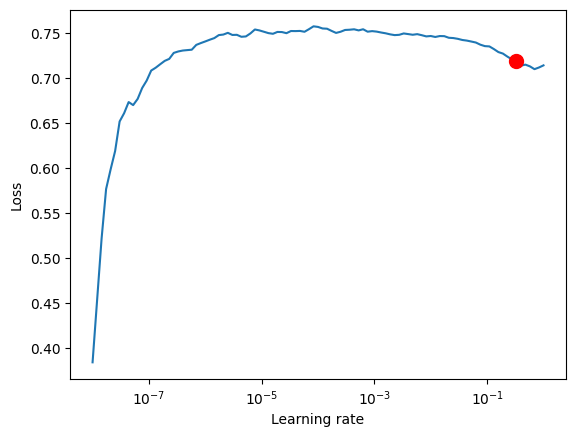

In [12]:
fig = lr_finder.plot(suggest=True)

In [14]:
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

0.3311311214825908


In [15]:
# update hparams of the model
lightning_model.learning_rate = new_lr

In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)

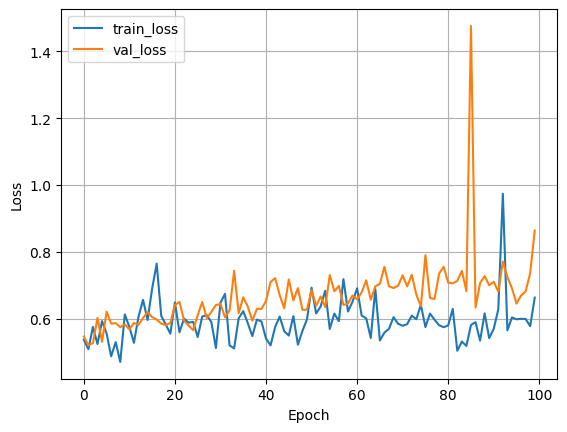

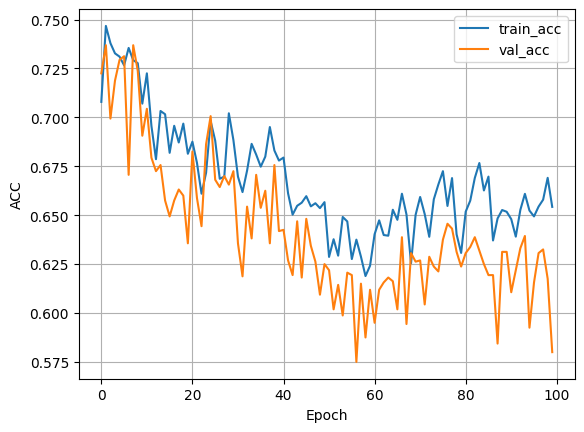

In [17]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("suggest_loss.pdf")

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

In [18]:
trainer.test(model=lightning_model, datamodule=dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5932499766349792     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5932499766349792}]

##3) No Scheduler

##4) Step Scheduler

##5) Reduce-on-Plateau Scheduler

##6) Cosine Annealing Scheduler